<a href="https://colab.research.google.com/github/BautiSobenko/IA-2022/blob/main/A1_VariacionDiametroArterial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## **Subtractive Clustering**

In [ ]:
"""Subtractive Clustering Algorithm
"""
__author__ = 'Daniel Albornoz'


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

def subclust2(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15
        
    scaler = MinMaxScaler()
    scaler.fit(data) 
    ndata = scaler.transform(data)
    
    # 14/05/2020 cambio list comprehensions por distance matrix
    #P = np.array([np.sum([np.exp(-(np.linalg.norm(u-v)**2)/(Ra/2)**2) for v in ndata]) for u in ndata])
    #print(P)
    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)
   
    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]
    
    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])            
        restarP = True  
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else: 
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)

    return labels, centers

## **Sugeno Implementation**

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed May  6 17:56:16 2020

@author: Daniel Albornoz

Implementación similar a genfis2 de Matlab.
Sugeno type FIS. Generado a partir de clustering substractivo.

"""
__author__ = 'Daniel Albornoz'

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import time

def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))
    
class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma
    
class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids

    
    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure(figsize=(12,8))
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.title("GAUSSIANAS - REGLAS: {}".format(self.centroids.size))
            plt.xlabel("Milisegundos") # Agregamos labels a los ejes
            plt.ylabel("Grado de pertenencia μ")
            plt.plot(x,y)
        
class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []
        
   
    
    def genfis(self, data, radii):

        start_time = time.time()
        labels, cluster_center = subclust2(data, radii)
        
        print("--- %s seconds ---" % (time.time() - start_time))
        n_clusters = len(cluster_center)
        
        cluster_center = cluster_center[:,:-1]
        P = data[:,:-1]
        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)       
     
        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)

    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]
        
        nivel_acti = np.array(f).T
        #print("nivel acti")
        #print(nivel_acti)
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        #print("sumMu")
        #print(sumMu)
        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]
        
        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        
        
        A = acti*inp/sumMu
        
        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu
        
        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        print(solutions)
        return 0

    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
         
        P = np.c_[data, np.ones(len(data))]
        
        n_vars = P.shape[1]
        n_clusters = len(self.rules)
        
        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions
        
        return np.sum(acti*inp*coef/sumMu,axis=1)
        
    
    def viewInputs(self):
        for input in self.inputs:
            input.view()

Monto Google Drive para poder importar el dataframe 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Me posiciono sobre la carpeta en el Drive

In [ ]:
%cd /content/drive/MyDrive/IA/

/content/drive/MyDrive/IA


In [ ]:
file = "samplesVDA3.txt"
df = pd.read_csv(file, header=None)

In [ ]:
df.head()

,0
0,273
1,275
2,281
3,292
4,309


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       153 non-null    int64
dtypes: int64(1)
memory usage: 1.3 KB


In [ ]:
df.describe()

,0
count,153.000000
mean,425.601307
std,98.844864
min,273.000000
25%,352.000000
50%,403.000000
75%,467.000000
max,661.000000


In [ ]:
frec_muestreo = 2.5 # milisegundos(ms)
x = np.arange(0,df.size*frec_muestreo,frec_muestreo)

In [ ]:
df.rename(columns={0:1},inplace=True)
df.insert(0,0,x)
df.head()

,0,1
0,0.0,273
1,2.5,275
2,5.0,281
3,7.5,292
4,10.0,309


1. Una vez cargado el DataFrame Ploteo los datos

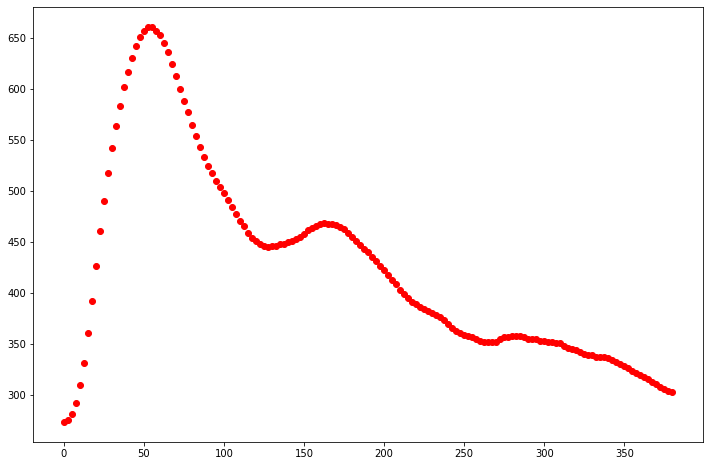

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(df[:][0],df[:][1],color="r");

Prueba del Subtractive Clustering con un Radio de inferencia = 0.5

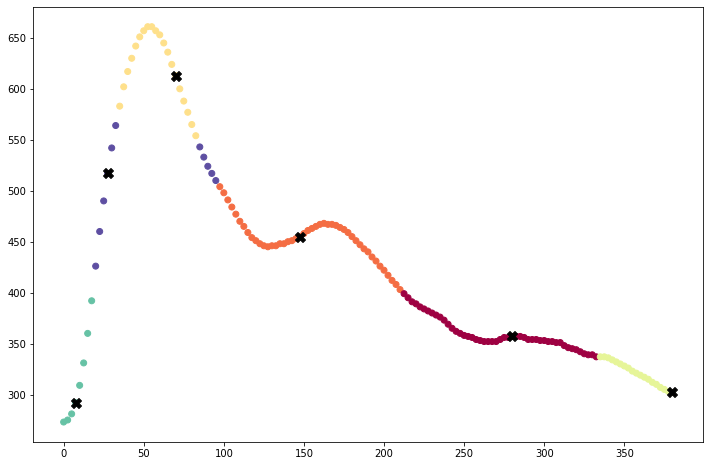

In [ ]:
r,c = subclust2(df,0.5)

plt.figure(figsize=(12,8))
plt.scatter(df[:][0],df[:][1],c = r,cmap="Spectral")
plt.scatter(c[:,0],c[:,1], c="black",marker="X",s=100);

Implementacion del **Mean square error**

In [ ]:
def mse (actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract (actual, pred)). mean() 

Testeo del FIS Sugeno

Fis Solutions: 

--- 0.12967228889465332 seconds ---
[-9.54647581e+09  6.51913155e+06  7.67268577e+09  8.18204634e+06
  7.44574160e+09 -2.42417348e+06  6.39050024e+09  8.11443109e+06
  5.37767585e+09 -8.19757974e+05 -8.42704632e+07  6.07174693e+05
  2.16853626e+09 -3.22035893e+06 -2.41333385e+09  3.24167446e+06
 -6.25468763e+09  1.09253228e+07  5.15122322e+08 -3.02177239e+06
 -3.60729185e+09 -2.61996383e+06 -3.56220307e+09 -1.00271725e+06
 -9.80200821e+09 -8.21243653e+05  3.56080259e+09 -2.69356713e+05
 -7.64183239e+08 -4.62941915e+05  2.66795930e+09  2.47960042e+06
  5.53196053e+09 -1.27635077e+06 -1.64696286e+09  2.12928254e+06
  2.81829823e+09 -2.22642946e+06  3.19670703e+09 -3.19184522e+06
  1.55226310e+09 -1.57967843e+06 -1.97426676e+08 -2.26306226e+06
  3.52237201e+09  4.30556039e+06 -3.22452365e+09  3.89679093e+06
  6.25147408e+09 -4.30820724e+06  1.27317908e+09 -4.18351126e+04
 -3.54497413e+09 -2.14404140e+06 -4.60925015e+09 -1.17140451e+06
  4.33144561e+09  3.43096085e+06  3.4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcPara

--- 0.0075206756591796875 seconds ---
[ -0.62811038 544.94227994]
--- 0.0037102699279785156 seconds ---
[ -0.62811038 544.94227994]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


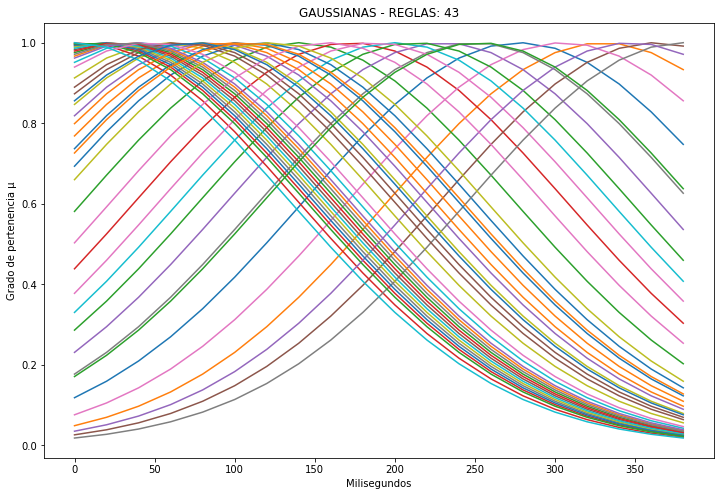

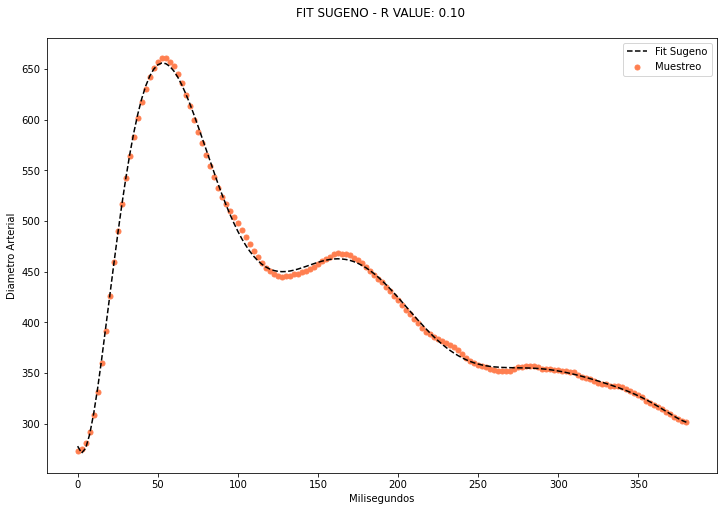

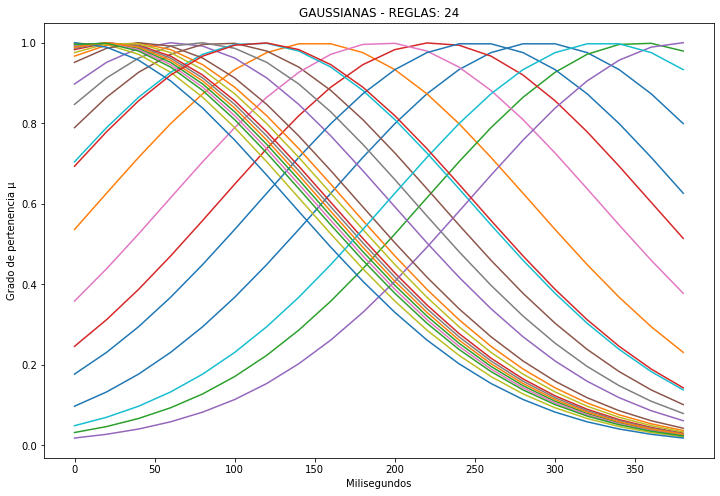

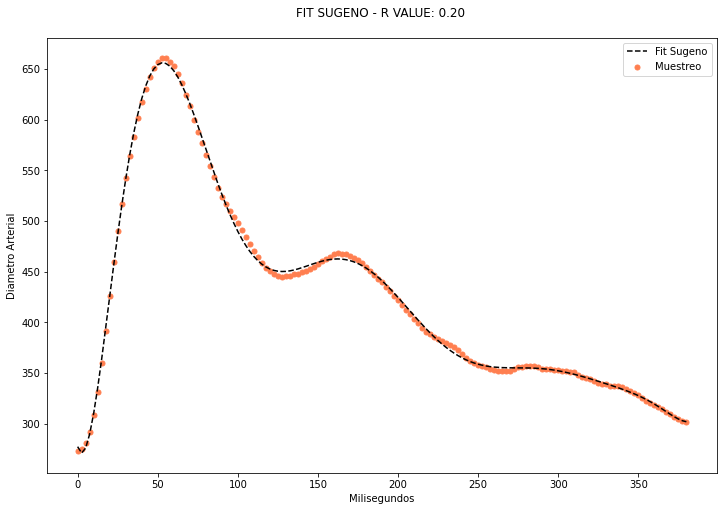

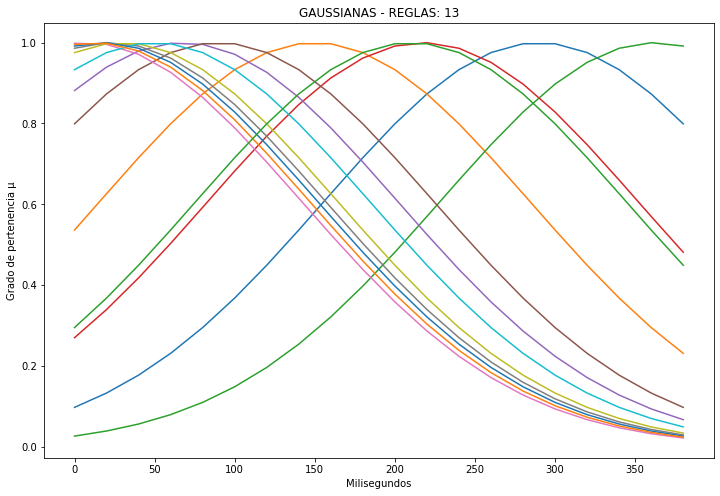

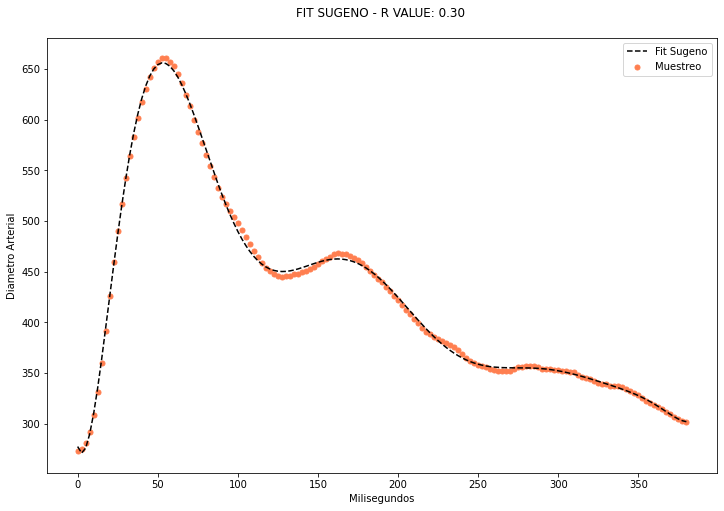

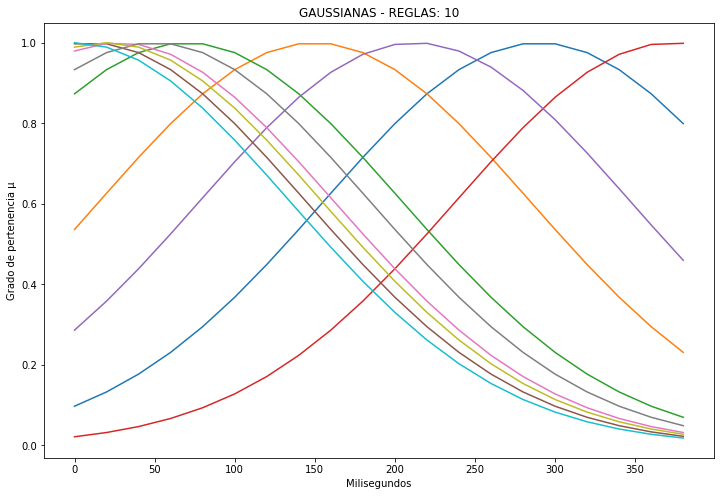

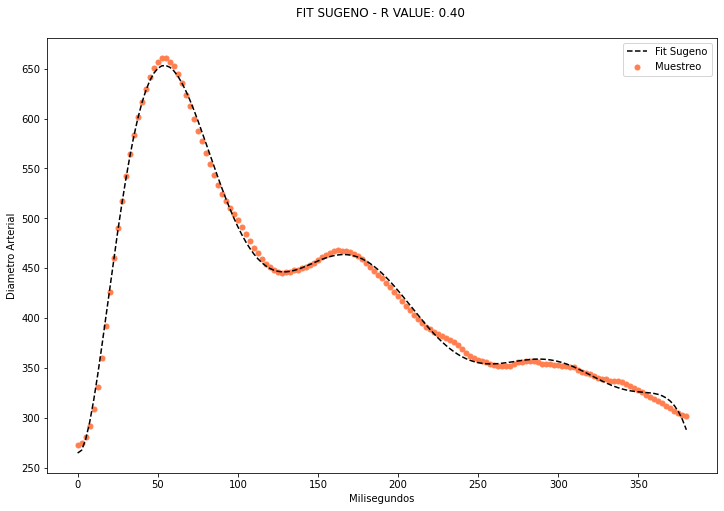

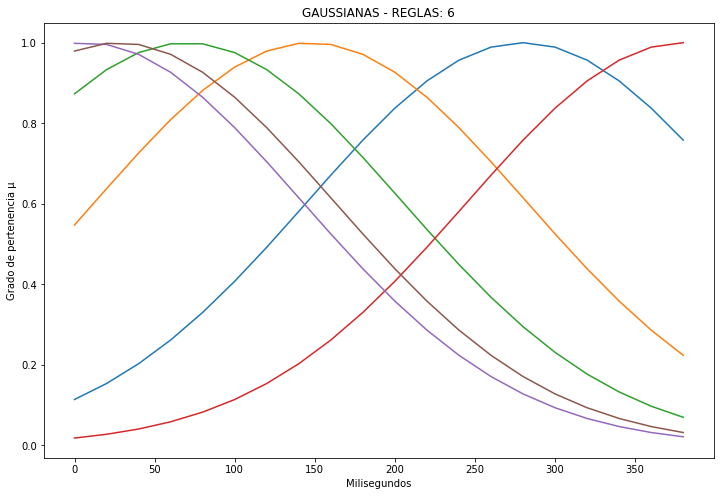

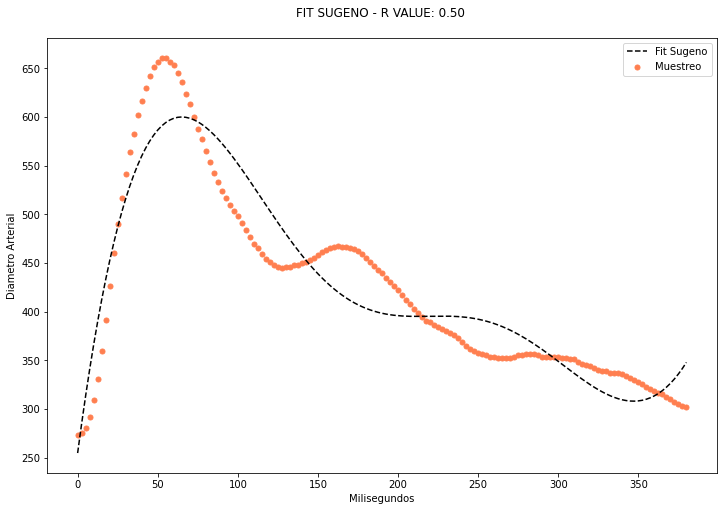

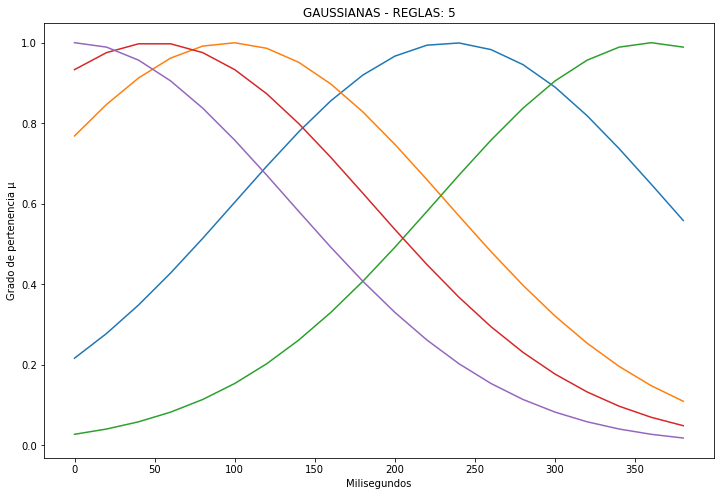

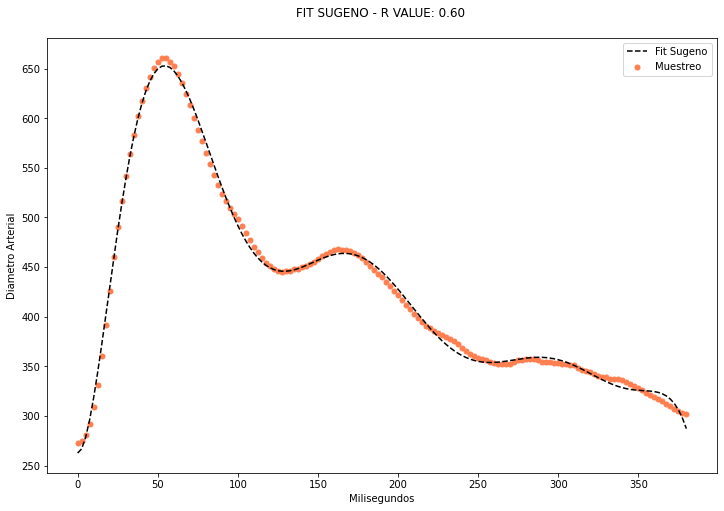

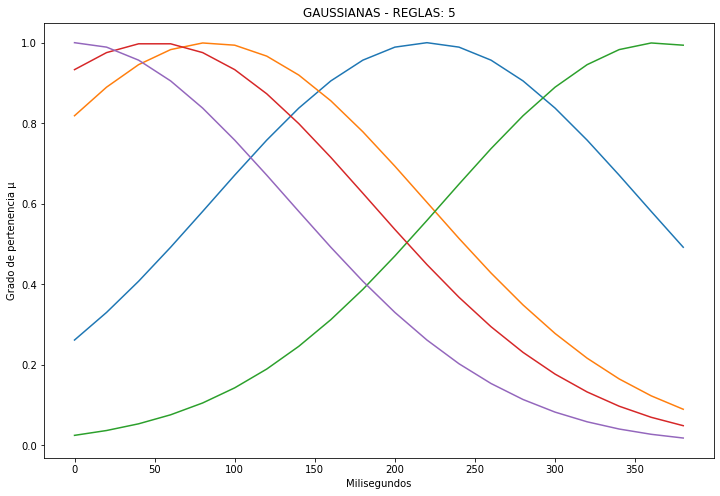

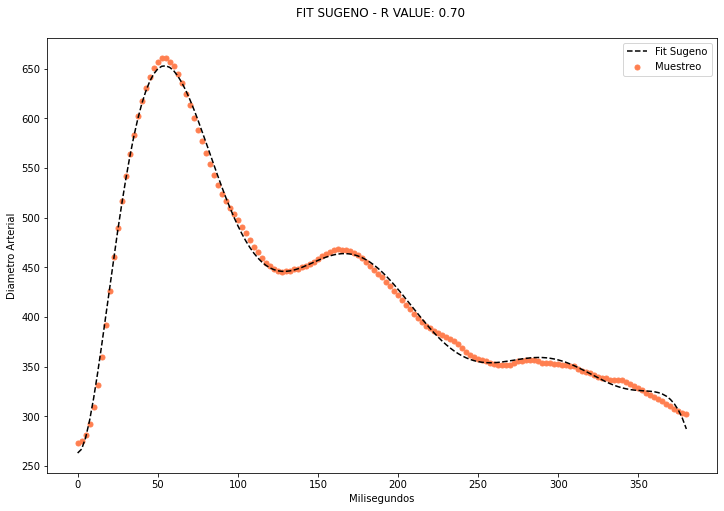

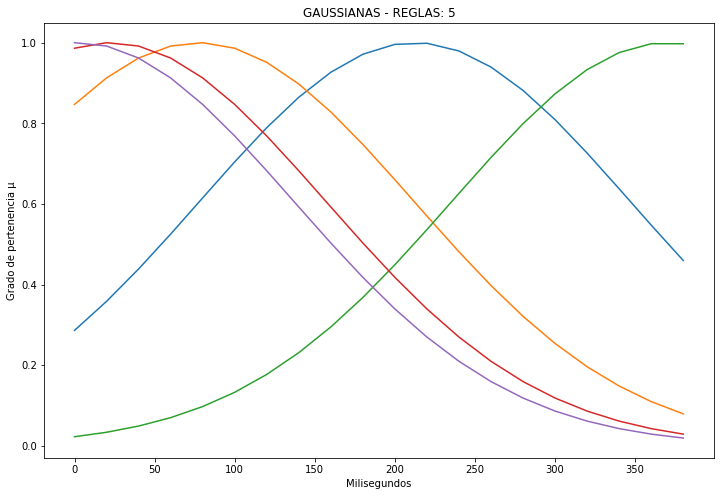

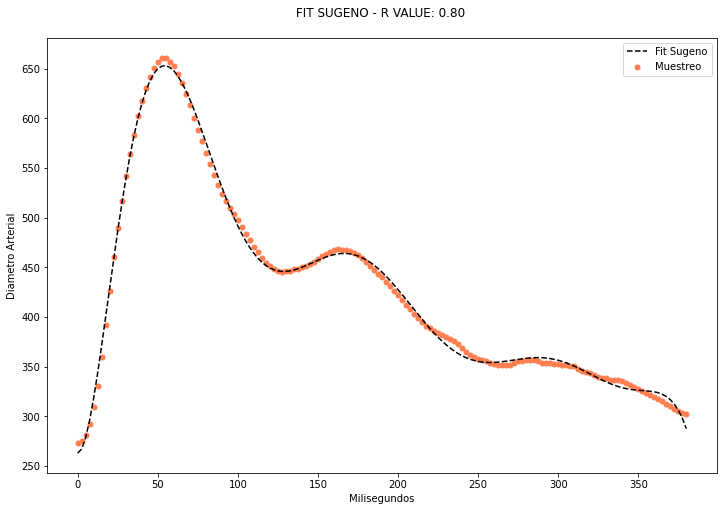

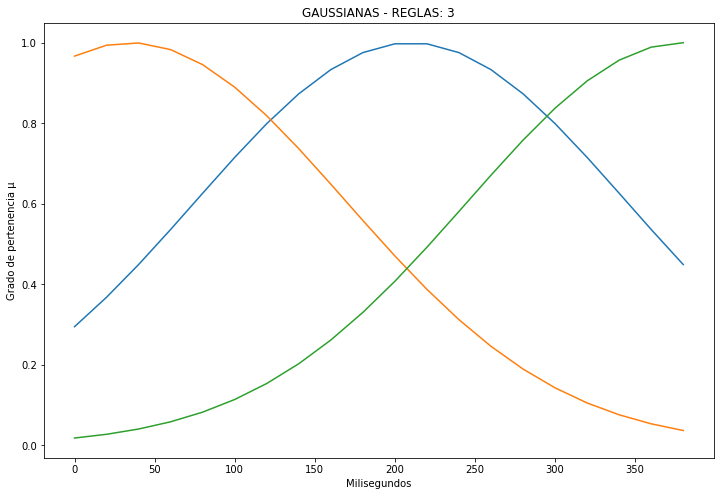

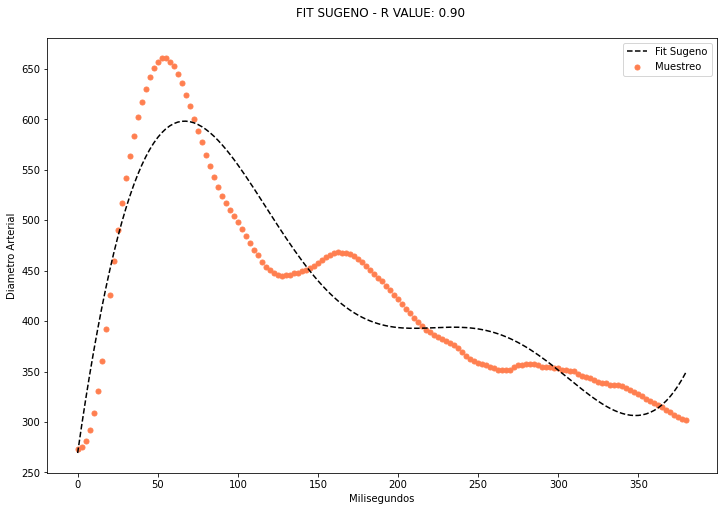

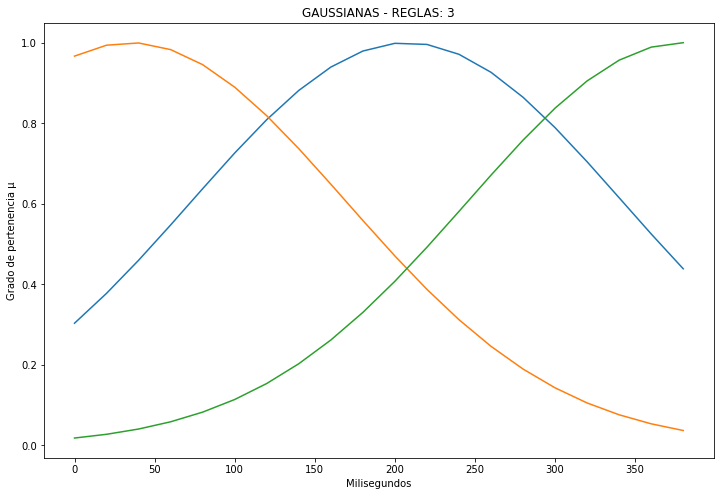

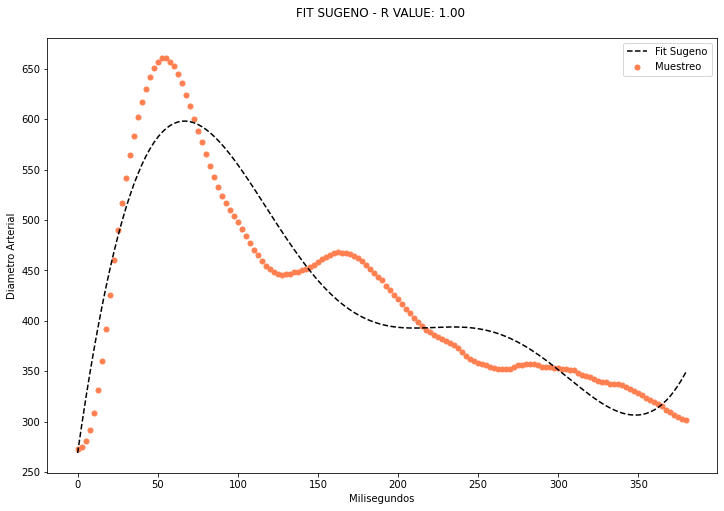

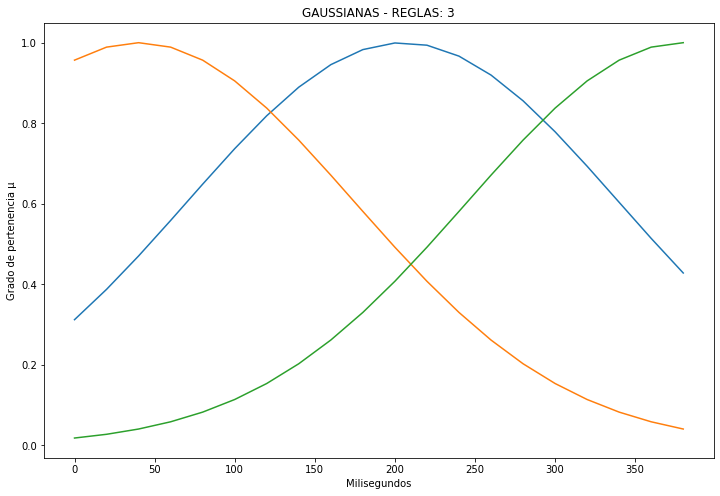

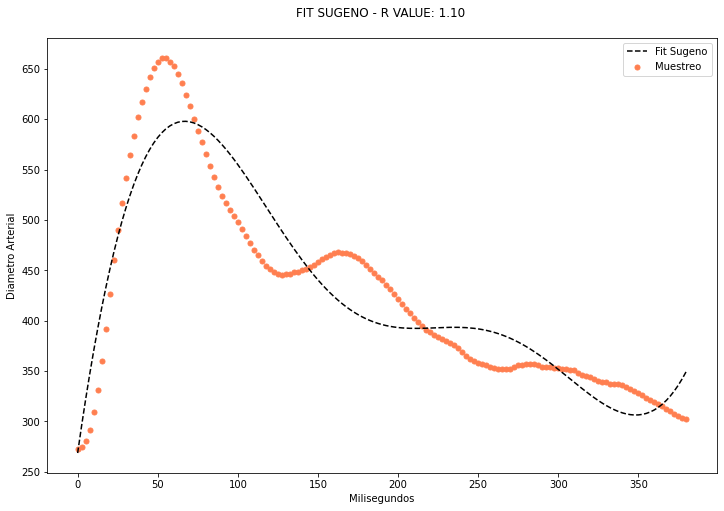

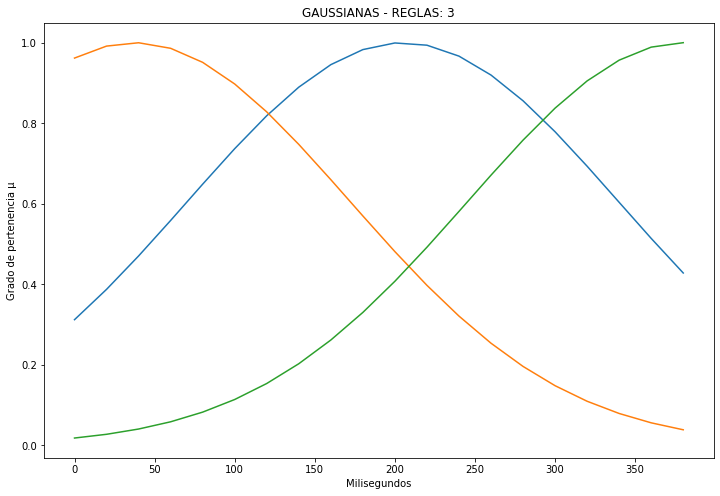

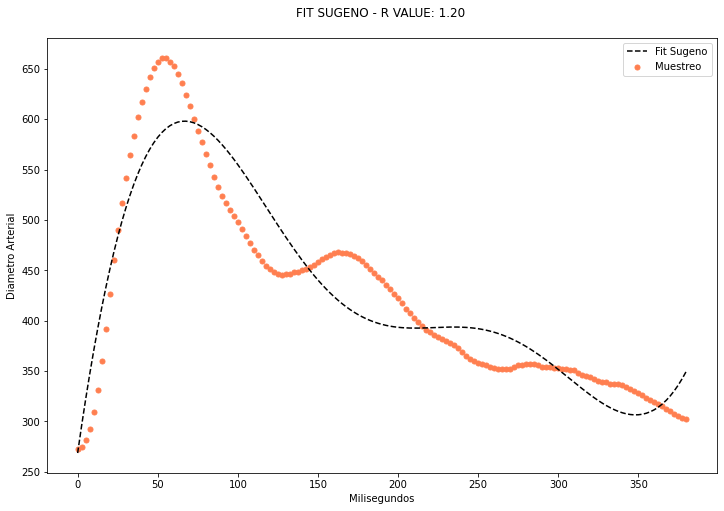

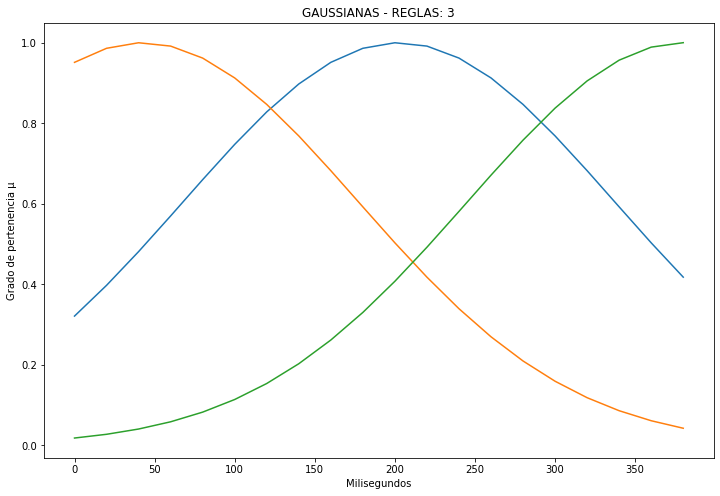

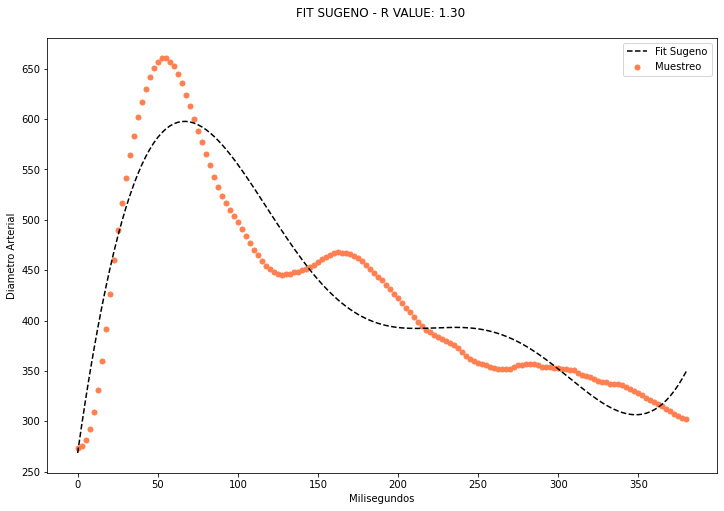

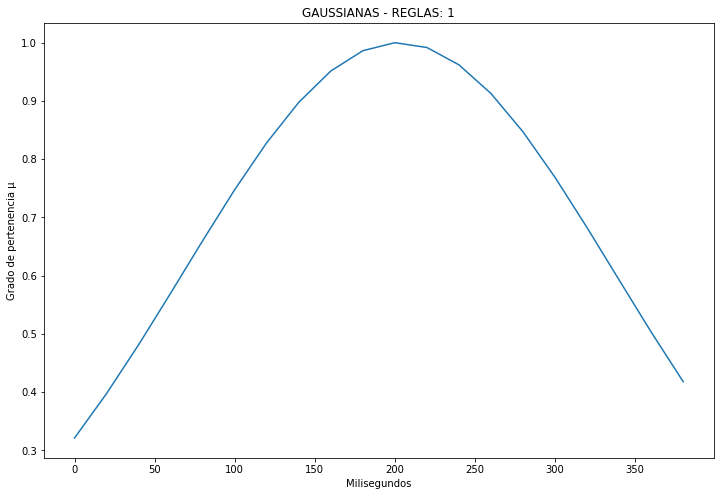

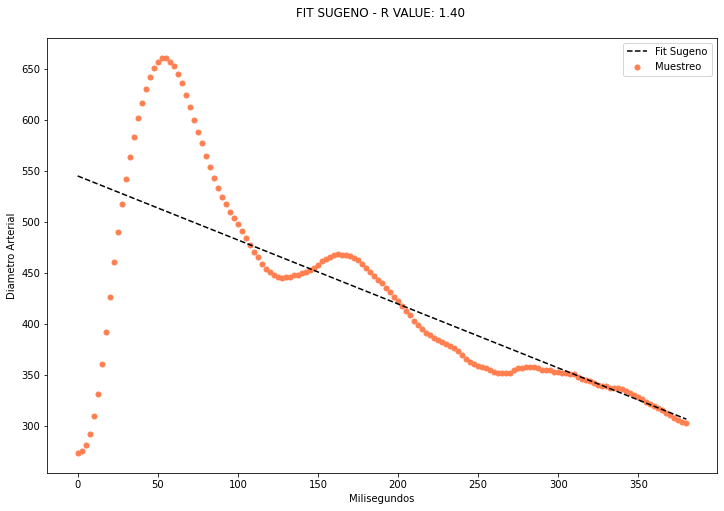

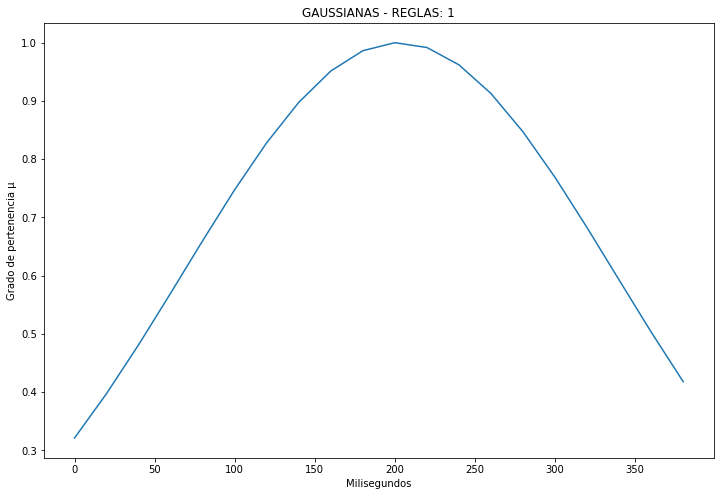

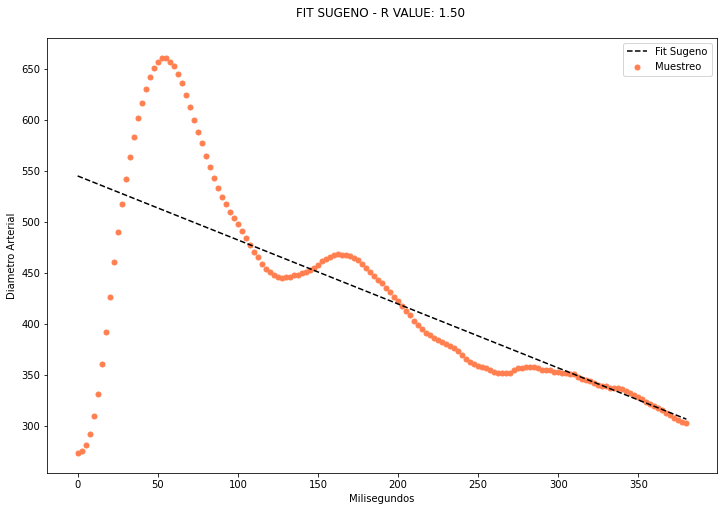

In [ ]:
np_df = np.array(df)
print("Fis Solutions: \n")

mse_arr = np.zeros((0,2))

for radii in np.arange(0.1,1.6,0.1):
  fis2 = fis()
  fis2.genfis(np_df, radii)
  fis2.viewInputs()

  r = fis2.evalfis(np.vstack(np_df[:,0]))
  
  row = np.array([radii,mse(r,df[:][1])])
  mse_arr = np.vstack([mse_arr,row])

  plt.figure(figsize=(12,8))
  plt.title("FIT SUGENO - R VALUE: {:.2f} \n".format(radii))
  plt.xlabel("Milisegundos") # Agregamos labels a los ejes
  plt.ylabel("Diametro Arterial")
  plt.scatter(df[:][0],df[:][1],c="coral",s=25)
  plt.plot(df[:][0],r,c="black",linestyle='--');
  plt.legend(["Fit Sugeno","Muestreo" ])


Ploteo del MSE vs R

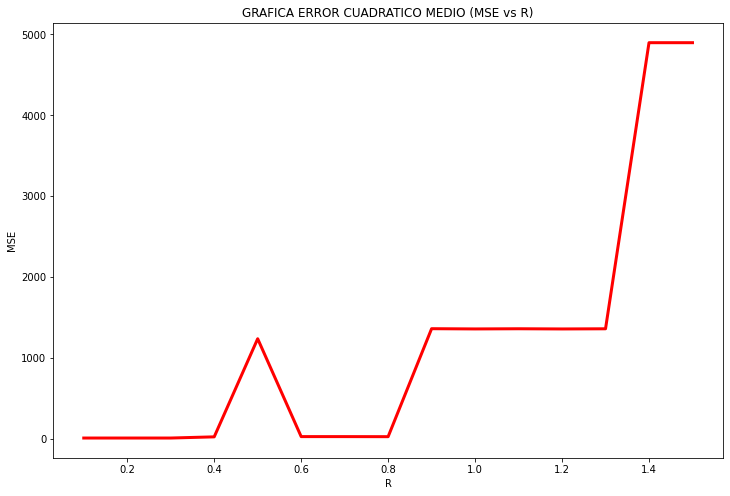

In [ ]:
plt.figure(figsize=(12,8))
plt.title("GRAFICA ERROR CUADRATICO MEDIO (MSE vs R)")
plt.xlabel("R")
plt.ylabel("MSE")
plt.plot(mse_arr[:,0],mse_arr[:,1],c="red",lw=3);